<a href="https://colab.research.google.com/github/wenjunsun/Covid-19-analysis-with-uw-ubicomp/blob/master/2020-11/GBM_and_RF_as_propensity_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, instead of using vanilla logistic regression to predict propensity score, we will use some data mining methods such as gradient boosting machine and random forest. And we will evaluate whether these methods generate better results than logistic regression.

# 0. load data/packages

In [1]:
cd drive/My\ Drive/fall

/content/drive/My Drive/fall


In [2]:
ls

counties_with_diff_and_all_covariates.csv
counties_with_diff.csv
county_data_with_covariates.csv
county_data_with_reduced_covariates_more_variables.csv
county_data_with_reduced_covariates_with_SIP.csv
county_data_with_reduced_covariates_with_SIP_up_to_5.csv
county_data_with_reduced_covariates_with_SIP_up_to_8.csv
LR_with_propensity_compare_SIP_and_no_SIP.ipynb
LR_with_propensity_score_buckets.ipynb
propensity_weighted_method.ipynb
PSM_new.ipynb
standardized_linear_regression.ipynb


In [3]:
import pandas as pd
import numpy as np

In [4]:
%load_ext rpy2.ipython
# For (automatic) translation of Pandas objects to R
from rpy2.robjects import pandas2ri
pandas2ri.activate()

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [6]:
# for box and whisker plot
%%R
install.packages('lattice')
library(lattice)

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/lattice_0.20-41.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 389631 bytes (380 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[wr

In [7]:
# install package for gradient boosting machine to estimate propensity score
%%R
install.packages('twang')
library(twang)

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/twang_1.6.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 1256084 bytes (1.2 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write t

In [13]:
# package in R for random forest
%%R
install.packages('party')

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/party_1.3-5.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 802880 bytes (784 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write 

In [14]:
%%R
library(party)

R[write to console]: Loading required package: mvtnorm

R[write to console]: Loading required package: modeltools

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: strucchange

R[write to console]: Loading required package: zoo

R[write to console]: 
Attaching package: ‘zoo’


R[write to console]: The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


R[write to console]: Loading required package: sandwich



In [8]:
data = pd.read_csv('county_data_with_reduced_covariates_with_SIP.csv')

In [9]:
data.dropna(inplace = True)

In [10]:
print(f"after dropping this dataset has {data.shape[0]} records.")

after dropping this dataset has 2995 records.


In [11]:
dataframe = data

# 1. How good is random forest at predicting propensity score

In [102]:
%%R
# create our formula for propensity score model.
covariateNames <- c(
    'Median.Household.Income',
    'X..Rural',
    'political_diff',
    'X..Asian',
    'X..Black',
    'X..Non.Hispanic.White',
    'X..Hispanic',
    'Population_y'
)
psFormula <- paste(covariateNames, collapse='+')
psFormula <- formula(paste('SIP.~', psFormula, sep=''))  
print(psFormula)

SIP. ~ Median.Household.Income + X..Rural + political_diff + 
    X..Asian + X..Black + X..Non.Hispanic.White + X..Hispanic + 
    Population_y


In [85]:
%%R -i dataframe
# a seed that ensures we get the same result if we run
# this code again in the future.
set.seed(2020)
# mytry = number of input variables we select for each tree
parameters <- cforest_unbiased(ntree = 500, mtry = 4)
randomForest <- cforest(psFormula, data=dataframe, controls = parameters)

In [86]:
%%R
# put probability predicted on each instance by RF into a
# column of dataframe as weights.
pScoresRf <- predict(randomForest, type='prob')
dataframe$weights <- matrix(unlist(pScoresRf),1,byrow=T)[1,]

In [87]:
%%R
head(dataframe)

  state state_code State.Name      cnamelong county_code diff_in_perc_at_home
0     1         AL    Alabama Autauga County        1001          0.050678282
1     1         AL    Alabama Baldwin County        1003          0.050311979
2     1         AL    Alabama Barbour County        1005          0.007036924
3     1         AL    Alabama    Bibb County        1007          0.011808926
4     1         AL    Alabama  Blount County        1009          0.038890321
5     1         AL    Alabama Bullock County        1011         -0.009576347
  SIP. Median.Household.Income X..Rural Population_y political_diff
0    1                   59338     42.0        55601    -0.49478934
1    1                   57588     42.3       218022    -0.57786162
2    1                   34382     67.8        24881    -0.05611165
3    1                   46064     68.4        22400    -0.55544124
4    1                   50412     90.0        57840    -0.81381973
5    1                   29267     51.4       

In [89]:
%%R
# convert 0, 1 to categories, as is required by the box whisker function
dataframe$factor_SIP <- factor(dataframe$SIP.)

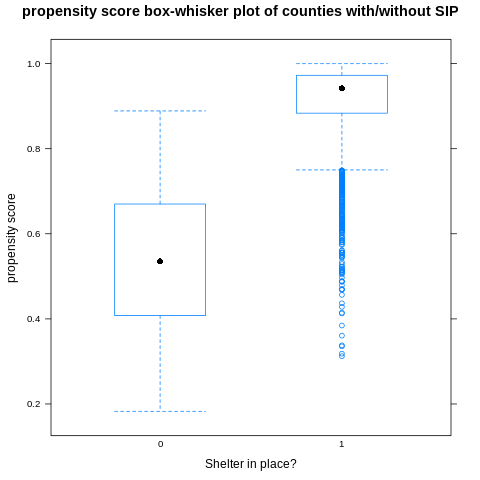

In [90]:
%%R
bwplot(weights~factor_SIP, data = dataframe, ylab = "propensity score", 
       xlab = "Shelter in place?", main = 'propensity score box-whisker plot of counties with/without SIP',
       auto.key = TRUE)

As we can see, the random forest isn't producing a balanced distribution of propensity scores.

In [91]:
%%R
# get weight for ATE based on propensity score
dataframe$weight_ATE <- with(dataframe, ifelse(SIP.==1, 1/weights, 1/(1-weights)))

In [ ]:
%%R
with(dataframe, by(weight_ATE, SIP., summary))

SIP.: 0
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.224   1.688   2.151   2.513   3.029   8.987 
------------------------------------------------------------ 
SIP.: 1
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.028   1.061   1.122   1.132   3.202 


As we can see, there are no extreme weights problem for RF, as we have seen for logistic regression

In [97]:
%%R
print(covariateNames)

[1] "Median.Household.Income" " X..Rural"              
[3] "political_diff"          "X..Asian"               
[5] "X..Black"                "X..Non.Hispanic.White"  
[7] "X..Hispanic"             "Population_y"           


In [98]:
%%R
head(dataframe)

  state state_code State.Name      cnamelong county_code diff_in_perc_at_home
0     1         AL    Alabama Autauga County        1001          0.050678282
1     1         AL    Alabama Baldwin County        1003          0.050311979
2     1         AL    Alabama Barbour County        1005          0.007036924
3     1         AL    Alabama    Bibb County        1007          0.011808926
4     1         AL    Alabama  Blount County        1009          0.038890321
5     1         AL    Alabama Bullock County        1011         -0.009576347
  SIP. Median.Household.Income X..Rural Population_y political_diff
0    1                   59338     42.0        55601    -0.49478934
1    1                   57588     42.3       218022    -0.57786162
2    1                   34382     67.8        24881    -0.05611165
3    1                   46064     68.4        22400    -0.55544124
4    1                   50412     90.0        57840    -0.81381973
5    1                   29267     51.4       

In [103]:
%%R
# sampw has to be set here or else will not get std.eff.sz which is what we want
# since we don't have sampling weight, we set it to 1
balanceTable <- bal.stat(dataframe, vars = covariateNames, treat.var = 'SIP.',
                         w.all = dataframe$weight_ATE, sampw = 1,
                         get.ks = F, estimand = 'ATE', multinom = F)

In [104]:
%%R
balance_results <- balanceTable$results 

In [105]:
%%R
round(balance_results,3) 

                             tx.mn      tx.sd     ct.mn     ct.sd std.eff.sz
Median.Household.Income  52976.427  14261.692 52025.900 10911.349      0.068
X..Rural                    56.317     31.048    60.846    29.674     -0.146
political_diff              -0.301      0.309    -0.382     0.240      0.264
X..Asian                     1.618      2.875     1.128     1.381      0.174
X..Black                     9.687     14.722     6.084    11.647      0.249
X..Non.Hispanic.White       75.644     20.170    80.222    15.859     -0.230
X..Hispanic                 10.001     14.334     6.955     7.265      0.220
Population_y            114252.289 349416.576 43256.776 82579.711      0.208
                          stat     p
Median.Household.Income  1.460 0.144
X..Rural                -2.652 0.008
political_diff           5.404 0.000
X..Asian                 5.192 0.000
X..Black                 4.581 0.000
X..Non.Hispanic.White   -4.696 0.000
X..Hispanic              6.044 0.000
Population_

As we can see, a lot of `std.eff.sz` are over `0.2`, which is bad news. Comparing to logistic regression, random forest isn't doing as good in terms of covariate balance.

# 2. How good is gradient boosting machine at propensity score modeling?

In [106]:
%%R -i dataframe

GBM <- ps(psFormula, data = dataframe, n.trees=5000, interaction.depth=4, estimand = 'ATE')

Fitting gbm model
Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        0.8404            -nan     0.0100      -nan
     2        0.8381            -nan     0.0100      -nan
     3        0.8358            -nan     0.0100      -nan
     4        0.8331            -nan     0.0100      -nan
     5        0.8310            -nan     0.0100      -nan
     6        0.8285            -nan     0.0100      -nan
     7        0.8264            -nan     0.0100      -nan
     8        0.8244            -nan     0.0100      -nan
     9        0.8224            -nan     0.0100      -nan
    10        0.8205            -nan     0.0100      -nan
    20        0.8020            -nan     0.0100      -nan
    40        0.7729            -nan     0.0100      -nan
    60        0.7505            -nan     0.0100      -nan
    80        0.7324            -nan     0.0100      -nan
   100        0.7173            -nan     0.0100      -nan
   120        0.7032            -nan     0.0100      -

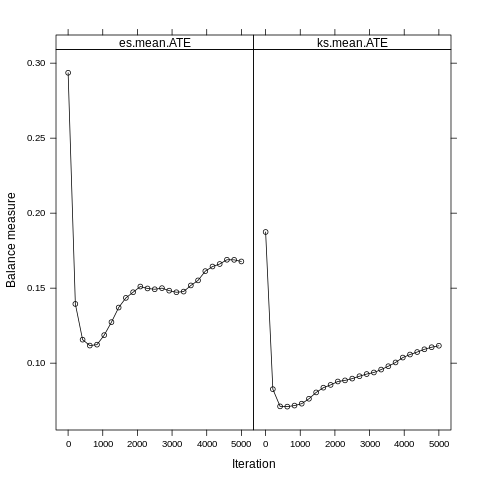

In [107]:
%%R
plot(GBM, type='b',color=F)

In [108]:
%%R
pScoresGBM <- GBM$ps

In [109]:
%%R
head(pScoresGBM)

  ks.mean.ATE es.mean.ATE
1   0.9521405   0.9536497
2   0.9368860   0.9374658
3   0.9169184   0.9162660
4   0.9318463   0.9342192
5   0.9189895   0.9217976
6   0.8963862   0.8989179


In [110]:
%%R
dataframe$weights <- pScoresGBM[,1]

In [113]:
%%R
# convert 0, 1 to categories, as is required by the box whisker function
dataframe$factor_SIP <- factor(dataframe$SIP.)

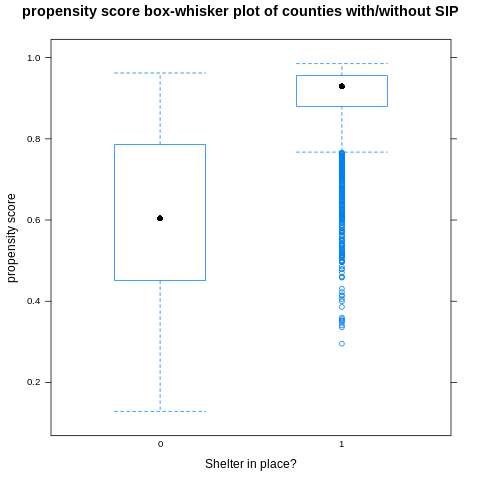

In [114]:
%%R
bwplot(weights~factor_SIP, data = dataframe, ylab = "propensity score", 
       xlab = "Shelter in place?", main = 'propensity score box-whisker plot of counties with/without SIP',
       auto.key = TRUE)

As we can see, the distributions are not matching up between the two. not good

In [115]:
%%R
# get weight for ATE based on propensity score
dataframe$weight_ATE <- with(dataframe, ifelse(SIP.==1, 1/weights, 1/(1-weights)))

In [116]:
%%R
with(dataframe, by(weight_ATE, SIP., summary))

SIP.: 0
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.148   1.821   2.527   4.146   4.672  26.408 
------------------------------------------------------------ 
SIP.: 1
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.015   1.046   1.076   1.143   1.136   3.386 


As we can see, there are no extreme weights problem for gradient boosting either.

In [117]:
%%R
# sampw has to be set here or else will not get std.eff.sz which is what we want
# since we don't have sampling weight, we set it to 1
balanceTable <- bal.stat(dataframe, vars = covariateNames, treat.var = 'SIP.',
                         w.all = dataframe$weight_ATE, sampw = 1,
                         get.ks = F, estimand = 'ATE', multinom = F)

In [118]:
%%R
balance_results <- balanceTable$results 

In [131]:
%%R
round(balance_results,3)

                             tx.mn      tx.sd     ct.mn      ct.sd std.eff.sz
Median.Household.Income  52998.635  14214.200 52031.073  11206.516      0.069
X..Rural                    56.430     30.956    54.585     30.342      0.060
political_diff              -0.302      0.308    -0.332      0.254      0.100
X..Asian                     1.620      2.892     1.324      1.480      0.105
X..Black                     9.611     14.638     8.127     13.105      0.103
X..Non.Hispanic.White       75.742     20.102    78.245     16.208     -0.126
X..Hispanic                  9.905     14.191     7.506      8.211      0.173
Population_y            113763.968 349106.007 62079.754 101813.026      0.152
                          stat     p
Median.Household.Income  1.238 0.216
X..Rural                 0.865 0.387
political_diff           1.555 0.120
X..Asian                 2.440 0.015
X..Black                 1.429 0.153
X..Non.Hispanic.White   -2.138 0.033
X..Hispanic              3.671 0.000
Po

It seems like gradient boosting provided better covariate balance than logistic regression! All the `std.eff.sz` are below `0.2`, the highest is about `0.17`

# 3. calculate effect size with GBM

In [120]:
propensity_weighted_data = %R dataframe

In [121]:
propensity_weighted_data.head()

,state,state_code,State.Name,cnamelong,county_code,diff_in_perc_at_home,SIP.,Median.Household.Income,X..Rural,Population_y,political_diff,X..less.than.18.years.of.age,X..65.and.over,X..Asian,X..Black,X..Hispanic,X..Non.Hispanic.White,weights,factor_SIP,weight_ATE
0,1.0,AL,Alabama,Autauga County,1001.0,0.050678,1,59338.0,42.0,55601,-0.494789,23.7,15.6,1.2,19.3,3.0,74.3,0.952140,1,1.050265
1,1.0,AL,Alabama,Baldwin County,1003.0,0.050312,1,57588.0,42.3,218022,-0.577862,21.6,20.4,1.2,8.8,4.6,83.1,0.936886,1,1.067366
2,1.0,AL,Alabama,Barbour County,1005.0,0.007037,1,34382.0,67.8,24881,-0.056112,20.9,19.4,0.5,48.0,4.3,45.6,0.916918,1,1.090610
3,1.0,AL,Alabama,Bibb County,1007.0,0.011809,1,46064.0,68.4,22400,-0.555441,20.5,16.5,0.2,21.1,2.6,74.6,0.931846,1,1.073138
4,1.0,AL,Alabama,Blount County,1009.0,0.038890,1,50412.0,90.0,57840,-0.813820,23.2,18.2,0.3,1.5,9.6,86.9,0.918990,1,1.088152


In [126]:
no_SIP_diff = np.average(propensity_weighted_data[propensity_weighted_data['SIP.'] == 0]['diff_in_perc_at_home'],
                         weights = propensity_weighted_data[propensity_weighted_data['SIP.'] == 0]['weight_ATE'])

In [127]:
SIP_diff = np.average(propensity_weighted_data[propensity_weighted_data['SIP.'] == 1]['diff_in_perc_at_home'], 
                      weights = propensity_weighted_data[propensity_weighted_data['SIP.'] == 1]['weight_ATE'])

In [128]:
no_SIP_diff

0.022721676462148486

In [129]:
SIP_diff

0.03208944997297552

In [130]:
SIP_diff - no_SIP_diff

0.009367773510827033

As we can see, the difference is still about 1%, which validated our research before. This GBM method doesn't have good overlapping support of propensisty score distribution though.